In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json
import os
import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import sklearn
from torchvision.transforms import InterpolationMode
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import math
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [2]:
torch.cuda.current_device()
torch.cuda.set_device(3)
print(torch.cuda.mem_get_info(torch.cuda.current_device()))
device = torch.cuda.current_device()

(94101424337760, 94101338278052)


In [25]:
# Hyper-parameters 
num_epochs = 80
batch_size = 1
learning_rate = 0.01

In [4]:
#READ THE LABELS.CSV FILE GENERATED IN PREPROCESSING.IPYNB, HEADER ALREADY GONE HERE!!!
image_id_and_labels = pd.read_csv('ids_and_labels_test.csv',delimiter=',',header=1)
#print(image_id_and_labels.values)
image_id_and_labels_arr = np.array(image_id_and_labels.values)
#print(image_id_and_labels_arr)

In [6]:
#TRAIN-VAL SPLIT AND SAVE AS SEPERATE CSV FILES

ids_labels_train, ids_labels_val = train_test_split(image_id_and_labels_arr, test_size=0.2, random_state=42)

stratSplit = StratifiedShuffleSplit(n_splits=1, test_size = 0.25, random_state=42)
for train_idx, test_idx in stratSplit.split(image_id_and_labels_arr, np.zeros(len(image_id_and_labels_arr))):
    ids_labels_train, ids_labels_val = image_id_and_labels_arr[train_idx], image_id_and_labels_arr[test_idx]
    

print(len(ids_labels_train))
print(len(ids_labels_val))
np.savetxt("ids_and_labels_test_seen.csv", ids_labels_train, delimiter=",", fmt='%s')
np.savetxt("ids_and_labels_test_unseen.csv", ids_labels_val, delimiter=",", fmt='%s')

348
117


In [8]:
image_id_and_labels_train = pd.read_csv('ids_and_labels_test_seen.csv',delimiter=',',header=1)
image_id_and_labels_train_arr = np.array(image_id_and_labels_train.values)
image_id_and_labels_val = pd.read_csv('ids_and_labels_test_unseen.csv',delimiter=',',header=1)
image_id_and_labels_val_arr = np.array(image_id_and_labels_val.values)
print(image_id_and_labels_train_arr)
print(image_id_and_labels_val_arr)


[['global_monthly_2019_11_mosaic_L15-0571E-1302N_2284_2983_13.tif' 3]
 ['global_monthly_2019_07_mosaic_L15-0369E-1244N_1479_3214_13.tif' 0]
 ['global_monthly_2018_08_mosaic_L15-1129E-0819N_4517_4915_13.tif' 7]
 ['global_monthly_2019_03_mosaic_L15-0744E-0927N_2979_4481_13.tif' 5]
 ['global_monthly_2020_01_mosaic_L15-0744E-0927N_2979_4481_13.tif' 5]
 ['global_monthly_2018_05_mosaic_L15-0369E-1244N_1479_3214_13.tif' 0]
 ['global_monthly_2018_07_mosaic_L15-0391E-1219N_1567_3314_13.tif' 1]
 ['global_monthly_2018_03_mosaic_L15-1670E-1159N_6681_3552_13.tif' 17]
 ['global_monthly_2019_05_mosaic_L15-1129E-0819N_4517_4915_13.tif' 7]
 ['global_monthly_2019_02_mosaic_L15-1546E-1154N_6186_3574_13.tif' 13]
 ['global_monthly_2018_09_mosaic_L15-1630E-0988N_6522_4239_13.tif' 15]
 ['global_monthly_2018_08_mosaic_L15-1670E-1159N_6681_3552_13.tif' 17]
 ['global_monthly_2019_03_mosaic_L15-1690E-1210N_6762_3348_13.tif' 18]
 ['global_monthly_2018_09_mosaic_L15-1670E-1159N_6681_3552_13.tif' 17]
 ['global_mont

In [9]:
repeated_ids_labels_train = np.repeat(image_id_and_labels_train_arr, repeats=16, axis=0)
repeated_ids_labels_val = np.repeat(image_id_and_labels_val_arr, repeats=16, axis=0)
print(repeated_ids_labels_train)

[['global_monthly_2019_11_mosaic_L15-0571E-1302N_2284_2983_13.tif' 3]
 ['global_monthly_2019_11_mosaic_L15-0571E-1302N_2284_2983_13.tif' 3]
 ['global_monthly_2019_11_mosaic_L15-0571E-1302N_2284_2983_13.tif' 3]
 ...
 ['global_monthly_2019_06_mosaic_L15-1630E-0988N_6522_4239_13.tif' 15]
 ['global_monthly_2019_06_mosaic_L15-1630E-0988N_6522_4239_13.tif' 15]
 ['global_monthly_2019_06_mosaic_L15-1630E-0988N_6522_4239_13.tif' 15]]


In [10]:
patch_index = 0
for row in range(repeated_ids_labels_train.shape[0]):
    repeated_ids_labels_train[row,0] = str(patch_index%16) + '!' + repeated_ids_labels_train[row,0] 
    patch_index += 1
print(repeated_ids_labels_train)

[['0!global_monthly_2019_11_mosaic_L15-0571E-1302N_2284_2983_13.tif' 3]
 ['1!global_monthly_2019_11_mosaic_L15-0571E-1302N_2284_2983_13.tif' 3]
 ['2!global_monthly_2019_11_mosaic_L15-0571E-1302N_2284_2983_13.tif' 3]
 ...
 ['13!global_monthly_2019_06_mosaic_L15-1630E-0988N_6522_4239_13.tif' 15]
 ['14!global_monthly_2019_06_mosaic_L15-1630E-0988N_6522_4239_13.tif' 15]
 ['15!global_monthly_2019_06_mosaic_L15-1630E-0988N_6522_4239_13.tif' 15]]


In [11]:
patch_index = 0
for row in range(repeated_ids_labels_val.shape[0]):
    repeated_ids_labels_val[row,0] = str(patch_index%16) + '!' + repeated_ids_labels_val[row,0] 
    patch_index += 1
print(repeated_ids_labels_val)

[['0!global_monthly_2019_03_mosaic_L15-1749E-1266N_6997_3126_13.tif' 19]
 ['1!global_monthly_2019_03_mosaic_L15-1749E-1266N_6997_3126_13.tif' 19]
 ['2!global_monthly_2019_03_mosaic_L15-1749E-1266N_6997_3126_13.tif' 19]
 ...
 ['13!global_monthly_2019_01_mosaic_L15-1666E-1189N_6665_3433_13.tif' 16]
 ['14!global_monthly_2019_01_mosaic_L15-1666E-1189N_6665_3433_13.tif' 16]
 ['15!global_monthly_2019_01_mosaic_L15-1666E-1189N_6665_3433_13.tif' 16]]


In [12]:
print(len(repeated_ids_labels_train))
print(len(repeated_ids_labels_val))
np.savetxt("ids_and_labels_test_seen_repeated.csv", repeated_ids_labels_train, delimiter=",", fmt='%s')
np.savetxt("ids_and_labels_test_unseen_repeated.csv", repeated_ids_labels_val, delimiter=",", fmt='%s')

5536
1840


In [209]:
class SN7Dataset(Dataset):
    
    def __init__(self, transform=None, train=True):
        
        if train == True:
            self.img_ids_labels = pd.read_csv("ids_and_labels_test_seen_filtered.csv", header = None) 
        else:
            self.img_ids_labels = pd.read_csv("ids_and_labels_test_unseen_filtered.csv", header = None)
            
        self.img_dir = '/local/home/stuff/datasets/Challenge_7/test_public'
        self.transform = transform
        
    def __getitem__(self, idx):
        
        image_id, patch_id = self.img_ids_labels.iloc[idx, 0].split("!")[1],self.img_ids_labels.iloc[idx, 0].split("!")[0]
        pattern = "mosaic_(.*?).tif"
        location_id = re.search(pattern, image_id).group(1)
        #print(image_id)
        #print(location_id)
        img_path = os.path.join(self.img_dir, location_id, 'images_masked', image_id )
        image = torchvision.transforms.ToTensor()(Image.open(img_path))[0:3,:,:]  #TAKE RGB CHANNELS ONLY FOR RESNET COMPATIBILITY!!!
        
        image_padded = torch.nn.functional.pad(image, pad=(0, 1024 - image.shape[2], 0, 1024 - image.shape[1]))
        patches = image_padded.unfold(1, 256, 256).unfold(2, 256, 256)
        patches = patches.reshape(3, -1, 256, 256)
        patches = patches.permute(1,0,2,3)
        
        image = patches[int(patch_id)]
        
        label = torch.from_numpy(np.asarray(self.img_ids_labels.iloc[idx, 1]))
        
        #print(image_id, patch_id)
        
        #patches = patches.view(-1, 3, 256, 256)
        #print(patches.shape)
        #label = label.flatten()
        #label = label.type(torch.LongTensor)
        
        if self.transform:
            image = self.transform(image)
                
            
        #if self.target_transform:
            #label = self.target_transform(label)
            
        
        return image, label
        
    def __len__(self):
        
        return len(self.img_ids_labels)

In [210]:
class GaussianBlur(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            sigma = np.random.rand() * 1.9 + 0.1
            #return img.filter(ImageFilter.GaussianBlur(sigma))
            transformed = transforms.functional.gaussian_blur(img, kernel_size=3, sigma=sigma)
            #print('after gaussian blur:', torch.sum(torch.isnan(transformed)) )
            return transformed
        else:
            return img


class Solarization(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            #return ImageOps.solarize(img)
            transformed = transforms.functional.solarize(img, threshold=0.5)
            #print('after solarization:', torch.sum(torch.isnan(transformed)) )
            return transformed
        else:
            return img
        
class Crop(object):
    def __call__(self, img):
        top = int(32*np.random.rand())
        left = int(32*np.random.rand())
        height = 256
        width = 256
        transformed = torch.empty(img.shape[0], 3, 224, 224)
        print(img.shape[0])
        for i in range(16):
            transformed[i] = torchvision.transforms.functional.resized_crop(img[i], top = top, left = left, height = height, width = width, size = 224)
            plt.imshow(transformed[i].permute(1,2,0))
        return transformed

In [211]:
#INSTANTIATE DATASETS
#transform = transforms.Compose(
            #[
                #transforms.RandomCrop(
                  #  224
                #),
                ##Crop(),
                #transforms.RandomApply(
                    #[
                        #transforms.ColorJitter(
                         #   brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1
                        #)
                    #],
                    #p=1.0,
                #),
                #transforms.RandomHorizontalFlip(p=0.5),
                #transforms.RandomGrayscale(p=0.2),
                #GaussianBlur(p=1.0),
                #Solarization(p=0.0),
                ##transforms.ToTensor(),
                #transforms.Normalize(
                 #   mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
                #),
            #]
        #)

        
transform = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
train_dataset = SN7Dataset(train=True, transform = transform)
val_dataset = SN7Dataset(train=False, transform = transform)

train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle = False)
val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle = False)

tensor(0)
tensor(0)
tensor([-1.0000, -0.9686, -0.9608, -0.9529, -0.9451, -0.9373, -0.9294, -0.9216,
        -0.9137, -0.9059, -0.8980, -0.8902, -0.8824, -0.8745, -0.8667, -0.8588,
        -0.8510, -0.8431, -0.8353, -0.8275, -0.8196, -0.8118, -0.8039, -0.7961,
        -0.7882, -0.7804, -0.7725, -0.7647, -0.7569, -0.7490, -0.7412, -0.7333,
        -0.7255, -0.7176, -0.7098, -0.7020, -0.6941, -0.6863, -0.6784, -0.6706,
        -0.6627, -0.6549, -0.6471, -0.6392, -0.6314, -0.6235, -0.6157, -0.6078,
        -0.6000, -0.5922, -0.5843, -0.5765, -0.5686, -0.5608, -0.5529, -0.5451,
        -0.5373, -0.5294, -0.5216, -0.5137, -0.5059, -0.4980, -0.4902, -0.4824,
        -0.4745, -0.4667, -0.4588, -0.4510, -0.4431, -0.4353, -0.4275, -0.4196,
        -0.4118, -0.4039, -0.3961, -0.3882, -0.3804, -0.3725, -0.3647, -0.3569,
        -0.3490, -0.3412, -0.3333, -0.3255, -0.3176, -0.3098, -0.3020, -0.2941,
        -0.2863, -0.2784, -0.2706, -0.2627, -0.2549, -0.2471, -0.2392, -0.2314,
        -0.2235, -0.

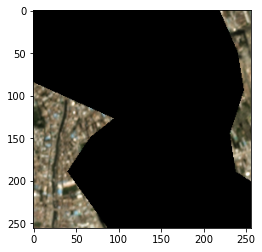

In [84]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(torch.sum(torch.isnan(images)))
print(torch.sum(torch.isinf(images)))
print(torch.unique(images))
print(labels)
print(images/2+0.5)

# show images
imshow(torchvision.utils.make_grid(images))

In [195]:
#FILTER THE BLANK IMAGES BOTH FROM TEST_SEEN!!!! BE SURE TO HAVE BATCH_SIZE=1, SHUFFLE=FALSE HERE AND DIRECTORY IN SN7 TO BE IDS_AND_LABELS_TEST_SEEN_REPEATED!!!!!
indeces_to_delete = []
for i, (inputs, labels) in enumerate(train_loader):
    #print(i)
    #if torch.sum( torch.logical_and( (inputs < 0.0001), (inputs > -0.0001)) ) >= 256*256/2:
    if torch.sum(torch.logical_and( torch.logical_and( inputs[0][0] < -0.9999, inputs[0][1] < -0.9999), inputs[0][1] < -0.9999) ) >= 256*256/2:
        indeces_to_delete.append(i)
print(indeces_to_delete)

[182, 186, 302, 303, 377, 816, 817, 818, 820, 824, 828, 829, 830, 831, 1168, 1600, 1604, 1605, 1612, 1933, 1934, 2240, 2243, 2244, 2248, 2473, 2477, 2518, 2522, 2526, 3154, 3155, 3158, 3159, 3161, 3162, 3163, 3166, 3167, 3242, 3243, 3320, 3321, 3324, 3325, 3486, 3487, 3799, 3803, 4211, 4215, 4219, 4223, 4385, 4388, 4641, 4643, 4647, 4651, 4652, 4653, 4655, 5047, 5050, 5051, 5054, 5055, 5056, 5057, 5058, 5063, 5067, 5071, 5427]


tensor([[17]])
torch.Size([3, 256, 256])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor(55289)


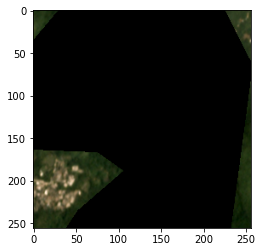

In [196]:
#SEE IF INDEED THE RIGHT PICTURES ARE CAPTURED
first_data = train_dataset[182]
img, label = first_data
plt.imshow(img.permute(1,2,0)/2+0.5)     #OTHER WAY TO PLOT????????
print((label.detach().reshape(-1,1)))
print(img.shape)
print(type(img))
print(type(label))
print(torch.sum(torch.logical_and( torch.logical_and( img[0] < -0.9999, img[1] < -0.9999), img[2] < -0.9999) ) ) 

In [197]:
image_id_and_labels = pd.read_csv('ids_and_labels_test_seen_repeated.csv',delimiter=',',header=None)
image_id_and_labels_arr = np.array(image_id_and_labels.values)
image_id_and_labels_arr_filtered = np.delete(image_id_and_labels_arr, indeces_to_delete, axis=0)
np.savetxt("ids_and_labels_test_seen_filtered.csv", np.array(image_id_and_labels_arr_filtered), delimiter=",", fmt='%s')
print('original:', image_id_and_labels_arr.shape)
print('filtered', image_id_and_labels_arr_filtered.shape)
print('indeces_to_delete', len(indeces_to_delete))

original: (5536, 2)
filtered (5462, 2)
indeces_to_delete 74


In [202]:
# CHECK TO SEE IF ANY MAJOR BLANK IMAGES IN NEW CSV FILE
for i, (inputs, labels) in enumerate(train_loader):
    #if torch.sum( torch.logical_and( (inputs < 0.0001), (inputs > -0.0001)) ) >= 256*256/2:
    if torch.sum(torch.logical_and( torch.logical_and( inputs[0][0] < -0.9999, inputs[0][1] < -0.9999), inputs[0][1] < -0.9999) ) >= 256*256/2:
        print(i)


In [203]:
#FILTER THE BLANK IMAGES BOTH FROM TEST_UNSEEN!!!!
indeces_to_delete = []
for i, (inputs, labels) in enumerate(val_loader):
    #print(i)
    #if torch.sum( torch.logical_and( (inputs < 0.0001), (inputs > -0.0001)) ) >= 256*256/2:
    if torch.sum(torch.logical_and( torch.logical_and( inputs[0][0] < -0.9999, inputs[0][1] < -0.9999), inputs[0][1] < -0.9999) ) >= 256*256/2:
        indeces_to_delete.append(i)
print(indeces_to_delete)

[174, 175, 464, 465, 466, 467, 468, 469, 470, 471, 492, 642, 646, 650, 651, 654, 655, 689, 693, 694, 704, 708, 709, 715, 718, 719, 737, 741, 837, 841, 842, 845, 846, 956, 957, 958, 964, 968, 972, 1344, 1348, 1443, 1451, 1454, 1455, 1632]


tensor([[17]])
torch.Size([3, 256, 256])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor(53239)


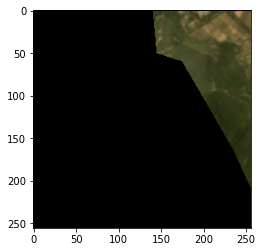

In [206]:
first_data = val_dataset[642]
img, label = first_data
plt.imshow(img.permute(1,2,0)/2+0.5)     #OTHER WAY TO PLOT????????
print((label.detach().reshape(-1,1)))
print(img.shape)
print(type(img))
print(type(label))
print(torch.sum(torch.logical_and( torch.logical_and( img[0] < -0.9999, img[1] < -0.9999), img[2] < -0.9999) ) ) 

In [207]:
image_id_and_labels = pd.read_csv('ids_and_labels_test_unseen_repeated.csv',delimiter=',',header=None)
image_id_and_labels_arr = np.array(image_id_and_labels.values)
image_id_and_labels_arr_filtered = np.delete(image_id_and_labels_arr, indeces_to_delete, axis=0)
np.savetxt("ids_and_labels_test_unseen_filtered.csv", np.array(image_id_and_labels_arr_filtered), delimiter=",", fmt='%s')
print('original:', image_id_and_labels_arr.shape)
print('filtered', image_id_and_labels_arr_filtered.shape)
print('indeces_to_delete', len(indeces_to_delete))

original: (1840, 2)
filtered (1794, 2)
indeces_to_delete 46


In [212]:
# CHECK TO SEE IF ANY MAJOR BLANK IMAGES IN NEW CSV FILE
for i, (inputs, labels) in enumerate(val_loader):
    #if torch.sum( torch.logical_and( (inputs < 0.0001), (inputs > -0.0001)) ) >= 256*256/2:
    if torch.sum(torch.logical_and( torch.logical_and( inputs[0][0] < -0.9999, inputs[0][1] < -0.9999), inputs[0][1] < -0.9999) ) >= 256*256/2:
        print(i)